[【基石策略】第一期：基于均线交叉与通道突破相结合的交易系统](https://www.ricequant.com/community/topic/3823/)

[2017-08-08 10:36:43.345354] INFO: system_log: rqdatac use socket ('q-rqdatad', 16003)
2016-01-14 INFO 下跌突破
2016-01-14 INFO 进场，空头开仓
2016-01-18 INFO 出场，空头平仓
2016-02-16 INFO 上升突破
2016-02-16 INFO 进场，多头开仓
2016-02-17 INFO 上升突破
2016-02-19 INFO 上升突破
2016-02-22 INFO 上升突破
2016-02-23 INFO 上升突破
2016-02-24 INFO 上升突破
2016-02-29 INFO 上升突破
2016-03-01 INFO 上升突破
2016-03-07 INFO 上升突破
2016-03-08 INFO 上升突破
2016-03-17 INFO 上升突破
2016-03-18 INFO 上升突破
2016-03-21 INFO 上升突破
2016-03-31 INFO 上升突破
2016-04-01 INFO 上升突破
2016-04-05 INFO 上升突破
2016-04-07 INFO 上升突破
2016-04-08 INFO 上升突破
2016-04-11 INFO 上升突破
2016-04-12 INFO 上升突破
2016-04-13 INFO 上升突破
2016-04-18 INFO 上升突破
2016-04-19 INFO 上升突破
2016-04-20 INFO 上升突破
2016-04-21 INFO 上升突破
2016-04-22 INFO 上升突破
2016-04-25 INFO 上升突破
2016-04-26 INFO 上升突破
2016-05-06 INFO 出场，多头平仓
2016-05-13 INFO 下跌突破
2016-05-13 INFO 进场，空头开仓
2016-05-23 INFO 下跌突破
2016-05-24 INFO 下跌突破
2016-05-25 INFO 下跌突破
2016-05-27 INFO 下跌突破
2016-06-06 INFO 出场，空头平仓
2016-06-29 INFO 上升突破
2016-06-29 INFO 进场，多头开仓
2016-06-30

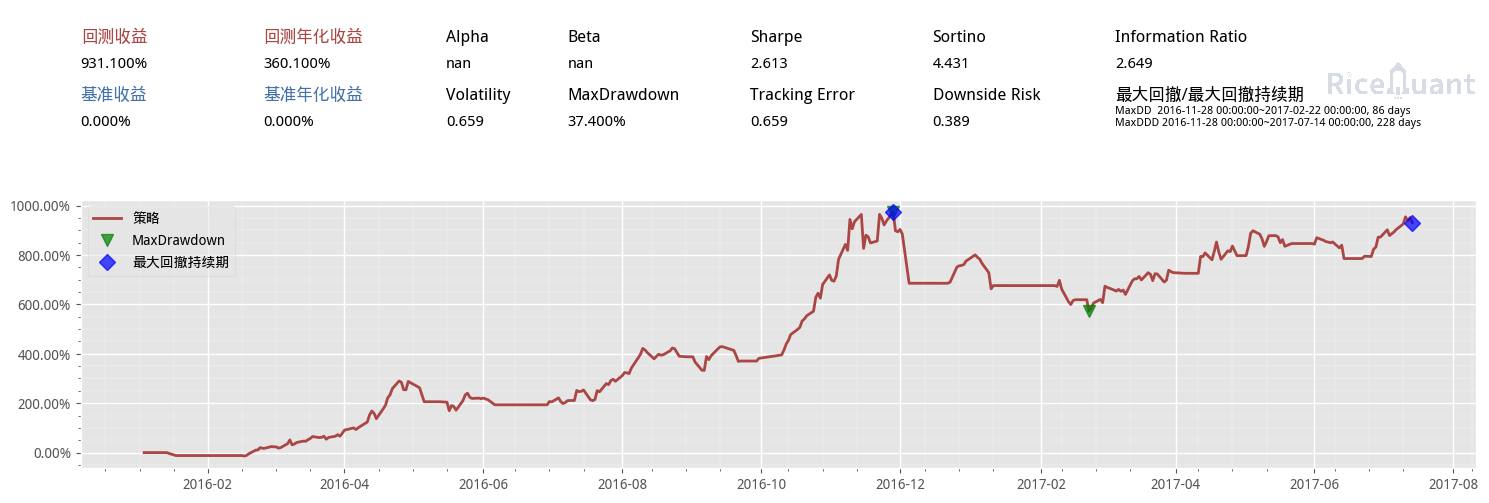

In [7]:
%%rqalpha_plus -s 20160101 -e 20170731 --account future 15000 -fq 1d -p 
# 上述命令参数可以通过运行 %%rqalpha_plus -h 查看到
 
def init(context):
    # 策略初始化运行
    context.s1 = 'J88'    # 标的为 J88
    context.FastLen = 9    # 快速均线周期数
    context.SlowLen = 18    # 慢速均线周期数
    context.ChLen = 12    # 通道突破的周期数
    context.ExtraPercentage = 0.001    # 通道突破的幅度
    context.TrailBar = 8    # 多少根 Bar 的最低价作为跟踪止损价
    context.InitalLots = 0    # 初始进场头寸
    context.ReBars = 15    # 再进场必须在出厂后多少根 Bar内
    context.ReEntryChLen = 10    # 再进场通道突破的周期数
    context.ReEntryLots = 0    # 再进场头寸
    context.Counter_HH = 0    # 高点计数器
    context.Counter_LL = 0    # 低点计数器
    context.Counter_ReBuy = 0    # 再进场做多的计数器
    context.Counter_ReSell = 0    # 再进场做空的计数器
    context.HH = 0.0    # 出场时的高点
    context.HH_15 = 0.0    #出场后 15 个 bar 的高点
    context.LL = 0.0    # 出场时的低点
    context.LL_15 = 0.0    #出场后 15 个 bar 的低点
    subscribe(context.s1)
    
def before_trading(context):
    # 每日开盘前运行
    pass

def get_close(context, bar_dict):
    # 每个 bar 数据运行
    # 取出数据
    Data = history_bars(context.s1, context.SlowLen + 1, '1d', ['close', 'high', 'low'], skip_suspended=True, include_now=False)     
    # 所需的收盘价不包括最近的一个 bar，体会一下
    Close = Data['close'][:-1]
    High = Data['high'][-(context.ChLen + 1): -1]
    Low = Data['low'][-(context.ChLen + 1): -1]
    # 以下计算各种均线值、高点值和低点值
    FastMA = Close[-context.FastLen:].mean()
    #print('FastMA', FastMA)
    SlowMA = Close.mean()
    #print('SlowMA', SlowMA)
    HH_12 = High.max()
    HH_10 = High[-context.ReEntryChLen:].max()
    HH_8 = High[-context.TrailBar:].max()
    LL_12 = Low.min()
    LL_10 = Low[-context.ReEntryChLen:].min()
    LL_8 = Low[-context.TrailBar:].min()

    return FastMA, SlowMA, HH_12, HH_10, HH_8, LL_12, LL_10, LL_8
    
def handle_bar(context, bar_dict):
    
    BuyQty=context.portfolio.positions[context.s1].buy_quantity    # 多头持仓
    SellQty=context.portfolio.positions[context.s1].sell_quantity    # 空头持仓
    
    FastMA, SlowMA, HH_12, HH_10, HH_8, LL_12, LL_10, LL_8 = get_close(context, bar_dict)    # 赋值
    #plot('FastMA', FastMA)
    #plot('SlowMA', SlowMA)

    if FastMA > SlowMA:    # 快速均线上穿慢速均线
        if context.Counter_LL > 0:    # 清空低点计数器
            context.Counter_LL = 0
        context.Counter_HH += 1    # 高点计数器开始计数
        #print('context.Counter_HH', context.Counter_HH)
        if context.Counter_HH <= 12:    # 高点在 12 个 bar 内
            #print('当前价位：', bar_dict[context.s1].high)
            #print('上升突破价位：', HH_12 * (1 + context.ExtraPercentage))    
            if bar_dict[context.s1].high > HH_12 * (1 + context.ExtraPercentage):    # 最近一个 bar 的高点突破“做多突破线”
                print('上升突破')
                # 空头平仓，多头开仓
                if SellQty > 0:
                    buy_close(context.s1, 1)
                    print('进场，空头平仓')
                if BuyQty == 0:
                    buy_open(context.s1, 1)
                    print('进场，多头开仓')
                    context.Counter_HH = 0    #  清空高点计数器
                    context.Counter_ReSell = 1    # 再进场做空的计数器开始计数
                    context.LL_10 = LL_10    # 存下出场时最近 10 个 bar（但不包括最近一个 bar，回看下 get_close） 的最低点
                    context.LL_15 = bar_dict[context.s1].low    # 存下出场时的低点
        if context.Counter_HH == 12:    # 12 个 bar 之后清空计数器
            context.Counter_HH = 0

    #进场及出场
    if FastMA < SlowMA:    # 快速均线下穿慢速均线
        if context.Counter_HH > 0:    # 清空高点计数器
            context.Counter_HH = 0
        context.Counter_LL += 1    # 低点计数器开始计数
        #print('context.Counter_LL', context.Counter_LL)
        if context.Counter_LL <= 12:  
            #print('当前价位：', bar_dict[context.s1].low)
            #print('下跌突破价位：', LL_12 * (1 - context.ExtraPercentage))   
            if bar_dict[context.s1].low < LL_12 * (1 - context.ExtraPercentage):    # 最近一个 bar 的低点突破“做空突破线”
                print('下跌突破')
                # 多头平仓，空头开仓
                if BuyQty > 0:
                    sell_close(context.s1, 1)
                    print('进场，多头平仓')
                if SellQty == 0:
                    sell_open(context.s1, 1)
                    print('进场，空头开仓')
                    context.Counter_LL = 0    #  清空低点计数器
                    context.Counter_ReBuy = 1    # 再进场做多的计数器开始计数
                    context.HH_10 = HH_10    # 存下出场时最近 10 个 bar（但不包括最近一个 bar，回看下 get_close）的最高点
                    context.HH_15 = bar_dict[context.s1].high   # 存下出场时的低高点
        if context.Counter_LL == 12:    # 12 个 bar 之后清空计数器
            context.Counter_LL = 0        

    # 周期性出场
    if BuyQty > 0:
        if bar_dict[context.s1].low < LL_8:   # 低点突破最近 8 个 bar（但不包括最近一个 bar，回看下 get_close）的最低点
            sell_close(context.s1, 1)
            print('出场，多头平仓')
            context.Counter_ReBuy = 1   # 再进场做多的计数器开始计数
            context.HH_10 = HH_10    # 存下出场时最近 10 个 bar（但不包括最近一个 bar，回看下 get_close）的最高点
            context.HH_15 = bar_dict[context.s1].high    # 存下出场时的高点
    
    if SellQty > 0:
        if bar_dict[context.s1].high > HH_8:   # 高点突破最近 8 个 bar（但不包括最近一个 bar，回看下 get_close）的最高点
            buy_close(context.s1, 1)
            print('出场，空头平仓')
            context.Counter_ReSell = 1   # 再进场做空的计数器开始计数
            context.LL_10 = LL_10    # 存下出场时最近 10 个 bar（但不包括最近一个 bar，回看下 get_close） 的最低点
            context.LL_15 = bar_dict[context.s1].low    # 存下出场时的低点

    # 再进场    
    if context.Counter_ReBuy > 0:    # 再进场做多的计数器已经开启
        context.HH_15 = max(context.HH_15, bar_dict[context.s1].high)    # 计算出场后最近 15 个 bar 的最高点
        context.Counter_ReBuy += 1
        if context.HH_15 > context.HH_10:
            if SellQty > 0:
                buy_close(context.s1, 1)
                print('再进场，空头平仓')
            if BuyQty == 0:
                buy_open(context.s1, 1)
                print('再进场，多头开仓')
    if context.Counter_ReBuy == 16:    # 16 个 bar 之后清空计数器
        context.Counter_ReBuy = 0
    
    if context.Counter_ReSell > 0:    # 再进场做空的计数器已经开启
        context.LL_15 = min(context.LL_15, bar_dict[context.s1].low)    # 计算出场后最近 15 个 bar 的最低点
        context.Counter_ReSell += 1
        if context.LL_15 < context.LL_10:
            if BuyQty > 0:
                sell_close(context.s1, 1)
                print('再进场，多头平仓')
            if SellQty == 0:
                sell_open(context.s1, 1)    
                print('再进场，空头开仓')
    if context.Counter_ReSell == 16:    # 16 个 bar 之后清空计数器
        context.Counter_ReSell = 0            
            
def after_trading(context):
    # 每日收盘后运行
    pass